# Neural Network

When and How to use a Neural Network

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
import pandas as pd
import numpy as np

df_filtered = pd.read_csv("../ignore_files/df_filtered.csv")
df_filtered.dropna(inplace=True)
df_filtered.head()

,vendor_id,passenger_count,trip_duration,Distance_KM,Manhattan_Distance,store_and_fwd_flag_V,pickup_cluster,dropoff_cluster,day_of_week,is_weekend,pickup_hour,time_of_day_category,is_holiday,pickup_day,pickup_month
0,2,1,455,1.498521,0.019859,0,3,4,0,0,17,Evening_Rush,0,14,3
1,1,1,663,1.805507,0.026478,0,3,0,6,1,0,Night,0,12,6
2,2,1,2124,6.385098,0.080158,0,3,0,1,0,11,Midday,0,19,1
3,2,1,429,1.485498,0.015480,0,0,0,2,0,19,Evening_Rush,0,6,4
4,2,1,435,1.188588,0.010818,0,4,4,5,1,13,Midday,0,26,3


## Normalization

In [3]:
from sklearn.preprocessing import OrdinalEncoder
#The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal integers.

store_fwd = OrdinalEncoder()
df_filtered['store_and_fwd_flag_V'] = store_fwd.fit_transform(df_filtered[['store_and_fwd_flag_V']])
df_filtered['time_of_day_category'] = store_fwd.fit_transform(df_filtered[['time_of_day_category']])


In [4]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, minmax_scale
from sklearn.compose import ColumnTransformer

# Define the target
# the model's target is 0 and 1 (integer)
df_filtered['vendor_id'] = df_filtered['vendor_id'].astype(int)

# Define categorical and numerical features
categorical_cols = ["store_and_fwd_flag_V","time_of_day_category", 'is_weekend','pickup_cluster', 'dropoff_cluster','is_holiday'] 

EXCLUDE_COL = categorical_cols
all_columns = df_filtered.columns
cols_to_scale = all_columns.drop(EXCLUDE_COL).tolist()
cols_retained = EXCLUDE_COL

# Separate the data
df_to_scale = df_filtered[cols_to_scale] # numerical columns that are going to be normalized
df_retained = df_filtered[cols_retained] # categorical columns

# Apply MinMax Scaling to the target columns ---
# We use minmax_scale which outputs a NumPy array. this makes the conversion faster
scaler_array = minmax_scale(df_to_scale, axis=0)

# Convert the scaled NumPy array back into a DataFrame
df_scaled = pd.DataFrame(scaler_array, columns=cols_to_scale)

# Recombine the scaled data with the retained column
# Concatenate the scaled columns (df_scaled) and the unscaled column (df_retained)
df_filtered_nor = pd.concat([df_scaled, df_retained], axis=1)


In [5]:
df_filtered_nor.shape
df_filtered_nor.head()

,vendor_id,passenger_count,trip_duration,Distance_KM,Manhattan_Distance,day_of_week,pickup_hour,pickup_day,pickup_month,store_and_fwd_flag_V,time_of_day_category,is_weekend,pickup_cluster,dropoff_cluster,is_holiday
0,1.0,0.0,0.131938,0.060421,0.054661,0.000000,0.739130,0.433333,0.4,0.0,1.0,0,3,4,0
1,0.0,0.0,0.192386,0.072802,0.072882,1.000000,0.000000,0.366667,1.0,0.0,4.0,1,3,0,0
2,1.0,0.0,0.616972,0.257505,0.220661,0.166667,0.478261,0.600000,0.0,0.0,2.0,0,3,0,0
3,1.0,0.0,0.124382,0.059896,0.042605,0.333333,0.826087,0.166667,0.6,0.0,1.0,0,0,0,0
4,1.0,0.0,0.126126,0.047921,0.029772,0.833333,0.565217,0.833333,0.4,0.0,2.0,1,4,4,0


In [6]:
num_classes = len(y.unique())

y = keras.utils.to_categorical(y, num_classes)

NameError: name 'y' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(X.shape[1],)),
        layers.Dense(64, activation="elu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [ ]:
'''
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

model.fit(
    X,
    y,
    epochs=20,
    verbose=1,
    validation_split=0.2,
    callbacks=[tensorboard_callback]
)
'''


'\nfrom tensorflow.keras.callbacks import TensorBoard\nimport datetime\n\nlog_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\ntensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)\n\nmodel.compile(\n    loss=\'categorical_crossentropy\',\n    optimizer=\'Adam\',\n    metrics=[\'accuracy\']\n)\n\nmodel.fit(\n    X,\n    y,\n    epochs=20,\n    verbose=1,\n    validation_split=0.2,\n    callbacks=[tensorboard_callback]\n)\n'

In [ ]:
# New imports needed for this method
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

# =================================================================
# 1. Environment Variable Configuration
# =================================================================
num_cpu_threads = os.cpu_count()
os.environ["OMP_NUM_THREADS"] = str(num_cpu_threads)
os.environ["TF_NUM_INTRAOP_THREADS"] = str(num_cpu_threads)
os.environ["TF_NUM_INTEROP_THREADS"] = str(num_cpu_threads)
print(f"--- Environment set to use {num_cpu_threads} threads. ---")

# =================================================================
# 2. Setup Data (Ensuring X and y are available)
# =================================================================
try:
    X.shape, y.shape 
except NameError:
    raise ValueError("X and y must be defined before running this script.")

input_dim = X.shape[1]
output_dim = y.shape[1]
BATCH_SIZE = 128 # reducing batch size for more noise into the gradient descent, which can sometimes help the model jump out of a local minimum and find a better, more accurate solution.

# =================================================================
# 3. CRITICAL: Create Optimized tf.data Dataset
# =================================================================

# 3a. Convert NumPy arrays to a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(buffer_size=10000) # Shuffle the data
dataset = dataset.batch(BATCH_SIZE)          # Define the batch size

# 3b. Use prefetch and AUTOTUNE for parallelism
# AUTOTUNE dynamically sets the best number of threads for optimal CPU usage.
dataset = dataset.prefetch(tf.data.AUTOTUNE) 

# Split the dataset into training and validation sets
train_size = int(0.8 * len(X))
train_dataset = dataset.take(int(train_size / BATCH_SIZE))
val_dataset = dataset.skip(int(train_size / BATCH_SIZE))

# =================================================================
# 4. Build, Compile, and Fit (Using the optimized dataset)
# =================================================================
model = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2), 
    Dense(256, activation='relu'), Dropout(0.2), 
    Dense(128, activation='relu'), 
    Dense(64, activation='relu'),
    Dense(output_dim, activation='softmax') 
])
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary(print_fn=lambda x: sys.stdout.write(x + '\n'))
# New Callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,           # Reduce learning rate by 50%
    patience=5,           # Wait 5 epochs before reducing
    min_lr=1e-5,          # Don't go below this value
    verbose=1
)

print("\nStarting Training with Optimized Data Pipeline...")
# Pass the TensorFlow Dataset objects to model.fit()
history = model.fit(
    train_dataset,
    epochs=30,
    callbacks=[lr_scheduler], #This automatically reduces the learning rate when the validation loss stops improving, allowing the model to make smaller, more careful adjustments 
    verbose=2,              
    validation_data=val_dataset, # Use the validation dataset
)
print("\nTraining finished.")


--- Environment set to use 32 threads. ---


c:\Progs\PySpark_Proj\spark_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 512)            │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼───────────────────

## Confusion Matrix

A confusion matrix is a table that summarizes how well your classification model performs by comparing actual labels (y_test) to predicted labels (y_pred).

It shows counts of correct and incorrect predictions, broken down by each class.

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X)

cm = confusion_matrix(y, y_pred)

44905/44905 ━━━━━━━━━━━━━━━━━━━━ 18s 390us/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

Confusion matrix, raw
[[134111      0]
 [     0 153278]]
Confusion matrix, raw
[[1. 0.]
 [0. 1.]]


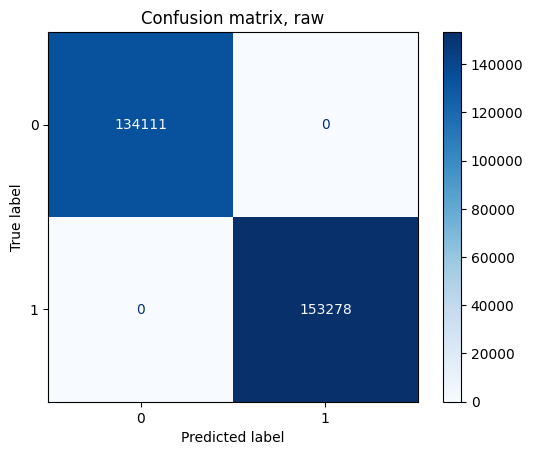

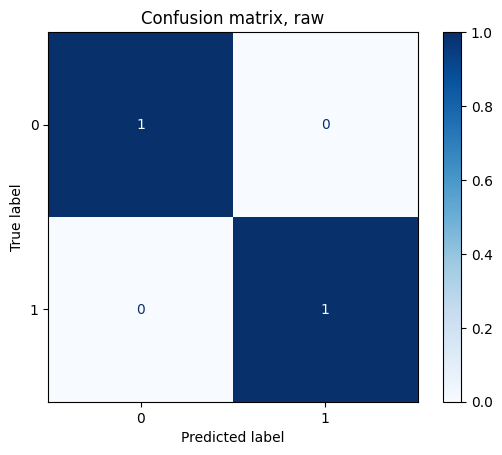

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
class_names = ['0', '1']

titles_options = [
    ("Confusion matrix, raw", None), #The raw counts of predictions
    ("Confusion matrix, raw", "true"), #The percentages of predictions
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Classification Report
1. **Precision** (The Quality of Positive Predictions)

Precision answers: "Out of all the trips the model said were Vendor X, how many actually were Vendor X?"


Formula: $\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$

Focus: It measures the accuracy of the positive predictions.

2. **Recall (The Completeness of Positive Predictions)**


Recall answers: "Out of all the trips that actually were Vendor X, how many did the model

Formula: $\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$

Focus: It measures the completeness of the result set.When it Matters: When the cost of a False Negative (failing to predict Vendor X when it was Vendor X) is high. For example, in anomaly detection, if you miss an actual fraudulent transaction (a False Negative), the cost could be enormous.

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X)

print(classification_report(y, y_pred, target_names=['0', '1'], zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    670011
           1       1.00      1.00      1.00    766933

    accuracy                           1.00   1436944
   macro avg       1.00      1.00      1.00   1436944
weighted avg       1.00      1.00      1.00   1436944



1. **Accuracy Score:**\
 Measures the percentage of correct predictions (both positive and negative).\
Accuracy=(TP+TN)/(TP+TN+FP+FN)\
2. **F1 Score**\
Combines precision and recall into a single metric using their harmonic mean. Imbalanced datasets, where accuracy can be misleading (e.g., predicting only the majority class).\
F1=2×(Precision+Recall)(Precision×Recall).
3. **Log Loss** (a.k.a. Cross-Entropy Loss) \
expects predicted probabilities, not binary class labels (0/1).Measures how confident your model’s probability predictions are.\


Summary Table
| Metric       | Input Type    | Range | Best Value | When to Use          |
| :----------- | :------------ | :---- | :--------- | :------------------- |
| **Accuracy** | Binary labels | 0–1   | 1.0        | Balanced data        |
| **F1 Score** | Binary labels | 0–1   | 1.0        | Imbalanced data      |
| **Log Loss** | Probabilities | 0–∞   | 0          | Probabilistic models |


In [ ]:
#evaluation metrics
#scores for train data
y_pred = model.predict(X_train)

acc_train = accuracy_score(y_train, y_pred)
f1_train = f1_score(y_train, y_pred)
ll_train = log_loss(y_train, y_pred)

print(f"(train) accuracy_score: {acc_train}")
print(f"(train) f1_score: {f1_train}")
print(f"(train) log_loss: {ll_train}")

print(f"{'#'*40}")
#scores for test
y_pred = model.predict(X_test)

acc_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
ll_test = log_loss(y_test, y_pred)

print(f"(test) accuracy_score: {acc_test}")
print(f"(test) f1_score: {f1_test}")
print(f"(test) log_loss: {ll_test}")

metrics = {
    "acc_train": acc_train,
    "f1_train": f1_train,
    "ll_train": ll_train,
    "acc_test": acc_test,
    "f1_test": f1_test,
    "ll_test": ll_test,
}
export_dict = {
    "model": model.__class__.__name__,
    "metrics": metrics,
}


(train) accuracy_score: 1.0
(train) f1_score: 1.0
(train) log_loss: 2.220446049250313e-16
########################################
(test) accuracy_score: 1.0
(test) f1_score: 1.0
(test) log_loss: 2.220446049250313e-16


In [ ]:
import os
CSV_FILE = "model_metrics.csv"
MODEL_KEY = 'model'
try:
    df_existing = pd.read_csv(CSV_FILE)
    print(f"Loaded existing data from '{CSV_FILE}' ({len(df_existing)} records).")
except (FileNotFoundError, pd.errors.EmptyDataError):
    df_existing = pd.DataFrame()

df_new_row = pd.json_normalize(export_dict)
# Check if the model name already exists in the existing DataFrame
model_name = df_new_row[MODEL_KEY].iloc[0]

if not df_existing.empty and model_name in df_existing[MODEL_KEY].values:
    print(f"Skipping: Model '{model_name}' already found in {CSV_FILE}.")
else:
    # If the model is new, combine the DataFrames
    print(f"Adding new model: '{model_name}'.")
    
    # Use pd.concat to merge, which automatically handles different columns (new metrics)
    df_combined = pd.concat([df_existing, df_new_row], ignore_index=True)
    
    # Export the combined DataFrame back to the CSV, overwriting the old file
    df_combined.to_csv(CSV_FILE, index=False)
    
    print(f"SUCCESS: Updated {CSV_FILE}. Total records: {len(df_combined)}.")    

## A manual qualitative inspection of the model's predictions on a very small subset of the data.

In [ ]:
small_sample = df_filtered_nor.sample(5).copy() #This randomly selects 5 rows from the normalized DataFrame

X_val = small_sample.drop(['vendor_id'], axis=1)
y_val = small_sample['vendor_id']

y_pred = y_pred = model.predict(X_val)
y_pred = pd.Series(y_pred, y_val.index)

for i in X_val.index:
    print(f'the index for this sample is: {i}')
    
    #for col in X_val.columns:
    #    print(f"{col} = {X_val[col][i]}") # Prints every input feature and its normalized value

    print(f"y_real = {y_val[i]}, y_pred = {y_pred[i]}, error = {y_val[i] - y_pred[i]}")
    
    print()

the index for this sample is: 692957
y_real = 0.0, y_pred = 0.0, error = 0.0

the index for this sample is: 898773
y_real = 1.0, y_pred = 1.0, error = 0.0

the index for this sample is: 426971
y_real = 1.0, y_pred = 1.0, error = 0.0

the index for this sample is: 584222
y_real = 1.0, y_pred = 1.0, error = 0.0

the index for this sample is: 981559
y_real = 1.0, y_pred = 1.0, error = 0.0



In [ ]:
# 5. Visualizations
from plotly.subplots import make_subplots
import plotly.graph_objects as go


df_filtered_nor_sample = df_filtered_nor.sample(500) #This randomly selects 500 rows from the normalized DataFrame

X_val = df_filtered_nor_sample.drop(['vendor_id'], axis=1)
y_val = df_filtered_nor_sample['vendor_id']


def iscorrect(x):
    return "circle" if x else "x"


iscorrectv = np.vectorize(iscorrect)
fig = make_subplots(rows=1, cols=1)

y_pred = model.predict(X_val)

fig.add_trace(go.Contour( #decision boundary 
    x=X_val['passenger_count'],
    y=X_val['Distance_KM'],
    z=y_pred,
    showscale=False,
    opacity=0.40,
    colorscale='portland'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=X_val['passenger_count'],
    y=X_val['Distance_KM'],
    mode='markers',
    marker_symbol=iscorrectv(y_val == y_pred),
    text=y_val,
    marker=dict(
        color=y_val,
        colorscale='portland'
    )
), row=1, col=1)
#the model thinks Vendor 0 should be (e.g., blue) and where Vendor 1 should be (e.g., red).
#fig.update_layout(showlegend=False)

fig.show()

In [ ]:

# 5. Visualizations
from plotly.subplots import make_subplots
df_filtered_nor_sample = df_filtered_nor.sample(500, random_state=42) # Use random_state for reproducibility

X_val = df_filtered_nor_sample.drop(['vendor_id'], axis=1)
y_val = df_filtered_nor_sample['vendor_id']


def iscorrect(x):
    # 'x' means incorrect prediction (error)
    # 'circle' means correct prediction
    return "circle" if x else "x" 

iscorrectv = np.vectorize(iscorrect)
fig = make_subplots(rows=1, cols=1, 
                    # Set the title of the plot clearly
                    subplot_titles=[f"Vendor Prediction Boundary (Time vs. Distance)"]
                   )

# 1. Generate Predictions for the Decision Boundary
y_pred = model.predict(X_val)

# --- TRACE 1: DECISION BOUNDARY (CONTOUR PLOT) ---
fig.add_trace(go.Contour(
    # New X-Axis: Time of Day
    x=X_val['pickup_hour'],
    # New Y-Axis: Trip Length
    y=X_val['Distance_KM'],
    z=y_pred,
    showscale=False,
    opacity=0.40,
    colorscale='portland',
    name='Model Prediction'
), row=1, col=1)

# --- TRACE 2: ACTUAL DATA POINTS (SCATTER PLOT) ---
fig.add_trace(go.Scatter(
    x=X_val['pickup_hour'],
    y=X_val['Distance_KM'],
    mode='markers',
    marker_symbol=iscorrectv(y_val == y_pred),
    text=[f"Actual Vendor: {int(v)}, Error: {int(e)}" for v, e in zip(y_val, y_val != y_pred)],
    marker=dict(
        color=y_val,
        colorscale='portland',
        size=8,
        line=dict(width=1, color='Black') # Helps errors stand out
    ),
    name='Actual Data & Errors'
), row=1, col=1)

# Update layout for clarity
fig.update_layout(
    xaxis_title='Pickup Hour (Scaled)',
    yaxis_title='Distance (KM) (Scaled)',
    height=600,
    width=900,
    showlegend=True,
    template='plotly_white'
)

fig.show()
